In [1]:
%matplotlib inline
%config IPCompleter.greedy=True

import copy
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
import scipy.stats as st
import auxiliary_functions as aux
import dfa_functions as dfaf
from scipy.optimize import curve_fit


pd.options.display.max_rows = 10

# Run the script to load the data (the series and their segmentation) and to delete all segments with indeterminate stage or whose max frequency is below 85%
from load_data import load_data, redo_classification
data, seg_res = load_data()
# Reclassificates the segments using the 4 stage system.
seg_res = redo_classification(seg_res, data)


## Detrended Fluctuation Analysis
***

### Description

We'll see if modifying the way the algorithm chooses the time scales to analyze changes the result. DFA, as originally defined, varies the time scales $n$ within a specified range. This range is arbitrarily defined and does not have a mathematical justificiation. The segmentation algorithm, on the other side, finds in the series intrinsic time scales. The modified DFA method, therefore, will analyze the fluctuations inside each segment (intrinsic time scale) in order to verify if there is a scaling behavior relating the fluctuations $F(n)$ and the segment sizes $n$.

The algorithm works as follows:

Given a HRV time-series $\{ x_i \}_{i = 1}^N$ of size $N$, we apply the segmentation algorithm that returns a set of segments $s_1, s_2, \ldots, s_k$ with sizes $n_1, n_2, \ldots, n_k$, respectively. We then integrate each segment, obtaining its profile, $y_r(j) = \sum_{i=1}^{j}\left[x_r(i) - \overline{x_r}\right]$, where $x_r(i)$ is the $i$th interval between heart beats and $\overline{x_r}$ is the sample mean within the $r$th segment, and $j = 1,\ldots,n_r$. For each segment, a polynomial curve, the tendency, is calculated using least squares. We denote $p_r(j)$ as the polynomial inside the $r$th segment. Then, we obtain the fluctuation inside the segment by calculating

$$
F(n_r) = \sqrt{\dfrac{1}{n_r}\cdot\sum_{j = 1}^{n_r}\left[y_r(j) - p_r(j)\right]}
$$

If there are $i$ and $j$ such that $n_i = n_j$, we take the average of $F(n_i)$ and $F(n_j)$, and sort the values based on the sizes $n_1, n_2, \ldots, n_k$. Finally, we obtain a curve by plotting $\log_{10}F(n) \; vs \;\log_{10}n$.

For our problem, we will separate the segments based on their sleep stages before proceeding with the algorithm, so that their curves can be compared.

#### Normal Series

In [2]:
series_t = ["Serie 0", "Serie 1", "Serie 2", "Serie 3"]

# Save the fluctuation functions for each series.
f_l = [[[], [], [], []],
       [[], [], [], []],
       [[], [], [], []]]

for g in range(3):
    for s in range(4):
        for stage in range(4):
            temp = []
            # The dfa_l function will return an array with the fluctuation function for each segmentation
            for i in range(len(seg_res[g])):
                temp.extend(dfaf.dfa_l(seg_res[g][i][s], data[g][i][series_t[s]], stage))
            
            # Sort the array by segment sizes
            temp = pd.DataFrame(np.sort(np.asarray(temp), axis = 0))
            f_l[g][s].append(temp)
                    
f_l = dfaf.tratamento(f_l, 4, log = 0)

##### Plots

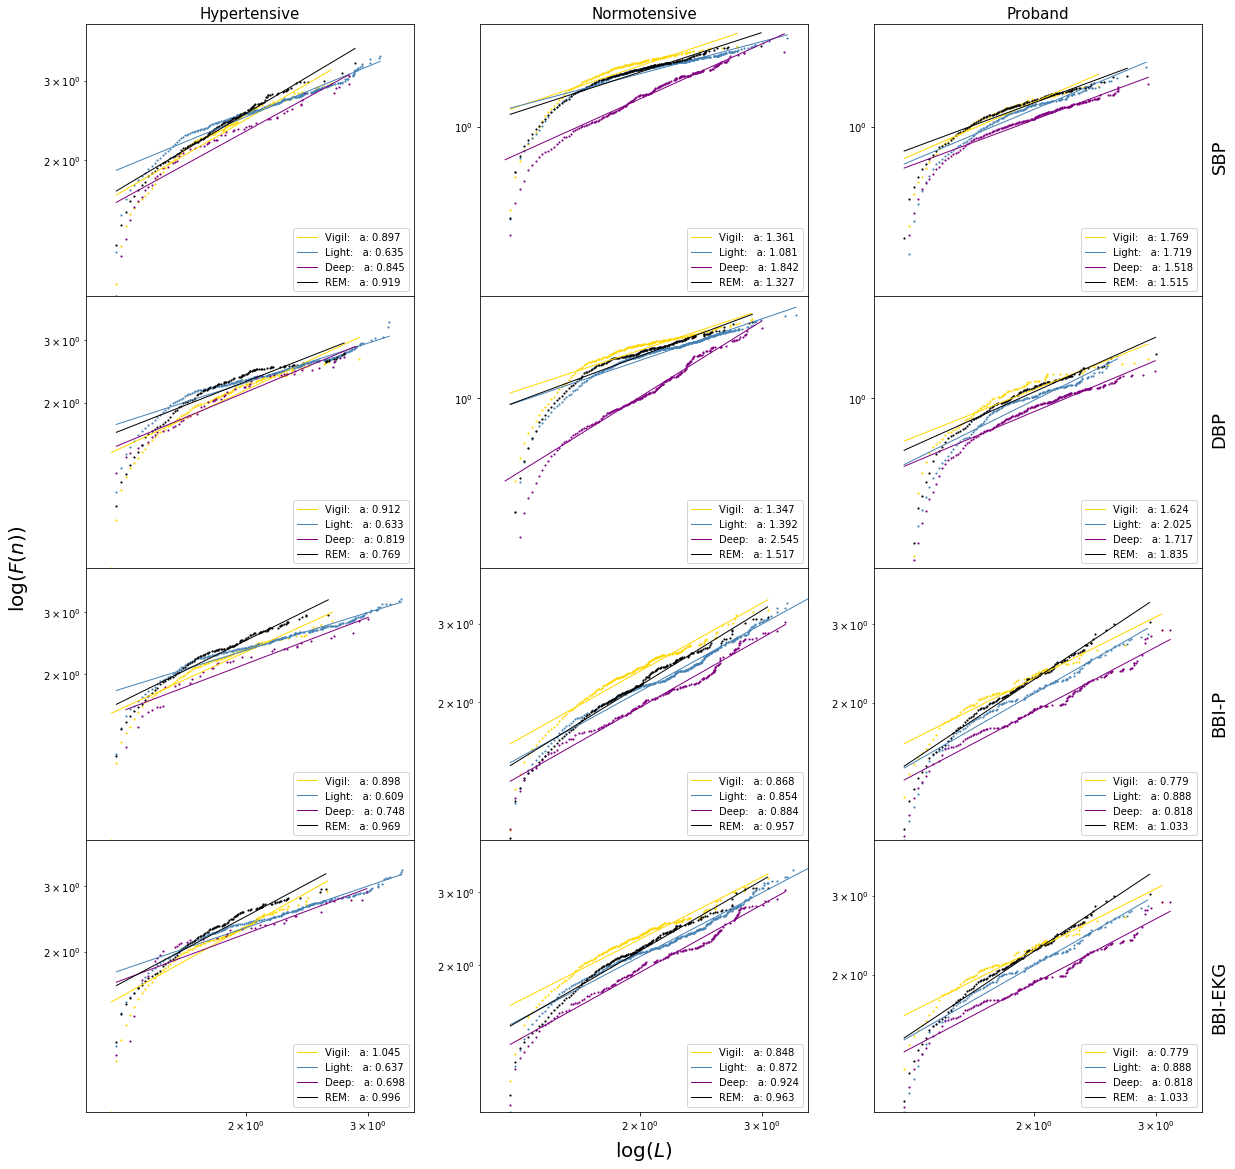

In [4]:


from scipy.optimize import curve_fit
def line(x, a, b):
    return np.power(10, a*np.log10(x) + b)

colors    = ["gold", "steelblue", "purple", "black"]
labels = ["Vigil", "Light", "Deep", "REM"]
groups = ["Hypertensive", "Normotensive", "Proband"]
series = ["SBP", "DBP", "BBI-P", "BBI-EKG"]

fig, axs = plt.subplots(nrows = 4, ncols = 3)
# Configure figure sizes and distance between axis
for item in [fig]:
    item.set_size_inches(20, 20)
    item.subplots_adjust(hspace = 0, wspace = 0.2)
        
coef_df = [pd.DataFrame(columns = ["SBP", "DBP", "BBI-P", "BBI-EKG"], index = np.arange(8)),
           pd.DataFrame(columns = ["SBP", "DBP", "BBI-P", "BBI-EKG"], index = np.arange(8)),
           pd.DataFrame(columns = ["SBP", "DBP", "BBI-P", "BBI-EKG"], index = np.arange(8))]
        
for g in range(3):
    for s in range(4):
        ax = axs[s][g]
        for p in range(4):
            stc = f_l[g][s]
            ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xlim(np.log10(15), 3.5)
            a = np.log10(min([stc[0]["coef"][0], stc[1]["coef"][0], stc[2]["coef"][0], stc[3]["coef"][0]]))
            if a < 0:
                ax.set_ylim(0.1, 4)
            else:
                ax.set_ylim(a, 4)
            
            if (len(stc) != 1):
                ax.scatter(np.log10(stc[p]["L"].values), np.log10(stc[p]["coef"].values), color = colors[p], s = 5, marker = ".", label = None)
                popt, pcov = curve_fit(line,np.log10(stc[p]["L"].values), np.log10(stc[p]["coef"].values))
                coef_df[g].loc[2*p, series[s]] = popt[0]
                coef_df[g].loc[2*p + 1, series[s]]  = np.sqrt(np.diag(pcov))[0]
                ax.plot(np.log10(stc[p]["L"].values), line(np.log10(stc[p]["L"].values), *popt), color = colors[p], linewidth = 1,
                       label = labels[p]+":   a: %5.3f" % popt[0])
                ax.legend(fontsize = 10, markerscale = 7, loc = 4)
        
        

# Configure title sizes
for i in range(4):
    for j in range(3):
        axs[i][j].xaxis.label.set_fontsize(20)
        axs[i][j].yaxis.label.set_fontsize(20)
        axs[i][j].xaxis.set_minor_locator(plt.NullLocator())
        axs[i][j].yaxis.set_minor_locator(plt.FixedLocator([2, 3]))
        axs[i][j].yaxis.set_major_locator(plt.NullLocator())
        

for i in [0, 1]:
    for j in [1, 2]:
        axs[i][j].yaxis.set_major_locator(plt.FixedLocator([1]))
        axs[i][j].yaxis.set_minor_locator(plt.NullLocator())
        
for i in [0, 1, 2]:
    axs[3][i].xaxis.set_major_locator(plt.FixedLocator([0, 1, 2, 3]))

axs[1][0].set_ylabel(r'$\log(F(n))$')
axs[1][0].yaxis.set_label_coords(-0.17,0)
axs[3][1].set_xlabel(r'$\log(L)$')
axs[3][1].xaxis.set_label_coords(0.5, -0.1)

axs[0][0].set_title("Hypertensive", size = 15)
axs[0][1].set_title("Normotensive", size = 15)
axs[0][2].set_title("Proband", size = 15)

axs[0][2].text(3.6, 0.7, "SBP", fontsize = 18, rotation = "vertical")
axs[1][2].text(3.6, 0.7, "DBP", fontsize = 18, rotation = "vertical")
axs[2][2].text(3.6, 2.0, "BBI-P", fontsize = 18, rotation = "vertical")
axs[3][2].text(3.6, 2.0, "BBI-EKG", fontsize = 18, rotation = "vertical")

fig.savefig("Plots/Measures/4 Groups/DFA_L/DFA_L_wline.png")
#plt.close(fig)

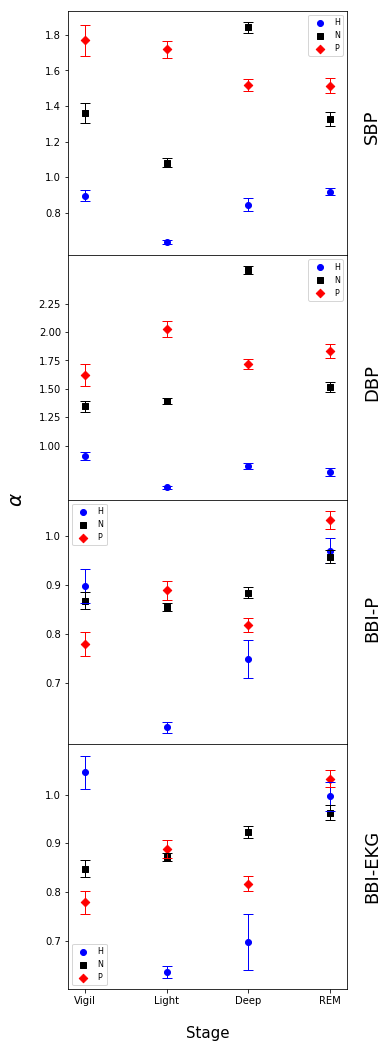

In [5]:
fig, axs = plt.subplots(nrows = 4)
# Configure fig sizes and distance between axis
for item in [fig]:
    item.set_size_inches(5, 18)
    item.subplots_adjust(hspace = 0)

# Configure title sizes
for i in range(4):
    axs[i].title.set_fontsize(14)
    axs[i].xaxis.label.set_fontsize(12)
    axs[i].yaxis.label.set_fontsize(15)
        
series = ["SBP", "DBP", "BBI-P", "BBI-EKG"]
group  = ["H", "N", "P"]
mkr = ['o', 's', 'D']
col = ["b", "k", "r"]

for s in range(4):
    ax = axs[s]
    for g in range(3):
        y = coef_df[g][series[s]][[0, 2, 4, 6]]
        y_err = coef_df[g][series[s]][[1, 3, 5, 7]]
        x = [0, 1, 2, 3]
        ax.scatter(x, y, color = col[g], marker = mkr[g], label = group[g])
        ax.errorbar(x, y, yerr = y_err, linestyle = "None", color = col[g], elinewidth = 1, capsize = 5, label = None)
        
    ax.legend(fontsize = 8, markerscale = 1)
    

for i in range(3):
    axs[i].set_xticks([])

axs[3].set_xticks([0, 1, 2, 3])
axs[3].set_xticklabels(["Vigil", "Light", "Deep", "REM"])
axs[3].set_xlabel("Stage", size = 15)
axs[1].set_ylabel(r'$\alpha$', size = 20)

axs[1].yaxis.set_label_coords(-0.15,0)
axs[3].xaxis.set_label_coords(0.5, -0.15)

axs[0].set_yticks([0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
axs[1].set_yticks([1, 1.25, 1.5, 1.75, 2, 2.25])
axs[2].set_yticks([0.7, 0.8, 0.9, 1])
axs[3].set_yticks([0.7, 0.8, 0.9, 1])

axs[0].text(3.4, 1.3, "SBP", fontsize = 18, rotation = "vertical")
axs[1].text(3.4, 1.6, "DBP", fontsize = 18, rotation = "vertical")
axs[2].text(3.4, 0.85, "BBI-P", fontsize = 18, rotation = "vertical")
axs[3].text(3.4, 0.9, "BBI-EKG", fontsize = 18, rotation = "vertical")

fig.savefig("Plots/Measures/4 Groups/DFA_L/DFA_L_meancoef.png")
#plt.close(fig)

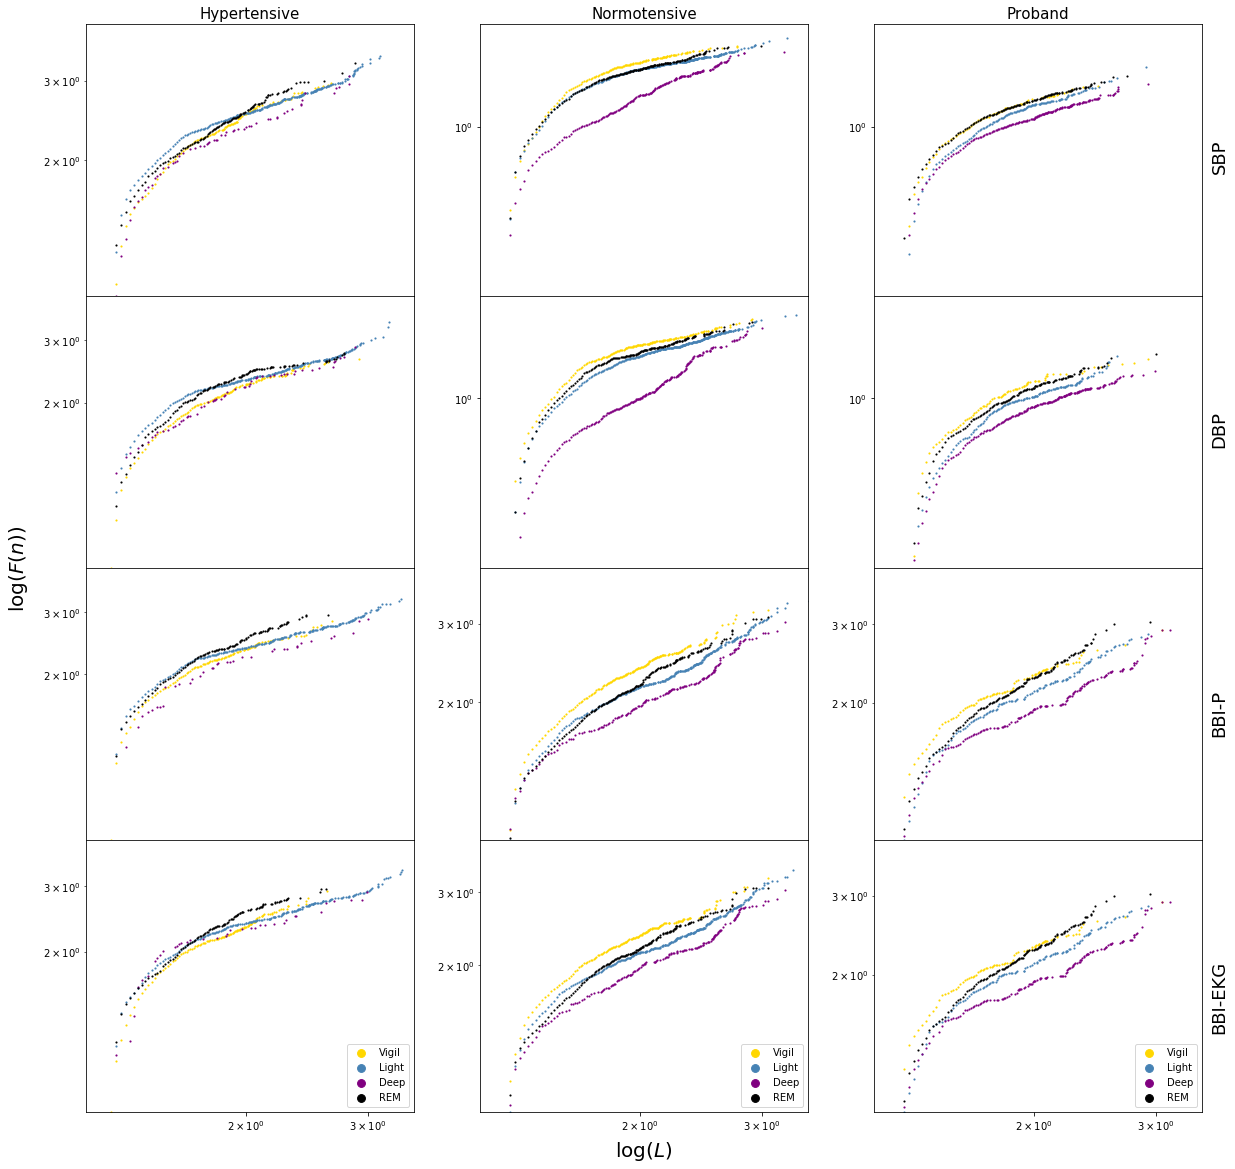

In [6]:
colors    = ["gold", "steelblue", "purple", "black"]
labels = ["Vigil", "Light", "Deep", "REM"]
groups = ["Hypertensive", "Normotensive", "Proband"]
series = ["SBP", "DBP", "BBI-P", "BBI-EKG"]

fig, axs = plt.subplots(nrows = 4, ncols = 3)
# Configure figure sizes and distance between axis
for item in [fig]:
    item.set_size_inches(20, 20)
    item.subplots_adjust(hspace = 0, wspace = 0.2)
        
for g in range(3):
    for s in range(4):
        ax = axs[s][g]
        for p in range(4):
            stc = f_l[g][s]
            ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xlim(np.log10(15), 3.5)
            a = np.log10(min([stc[0]["coef"][0], stc[1]["coef"][0], stc[2]["coef"][0], stc[3]["coef"][0]]))
            if a < 0:
                ax.set_ylim(0.1, 4)
            else:
                ax.set_ylim(a, 4)
            
            if (len(stc) != 1):
                ax.scatter(np.log10(stc[p]["L"].values), np.log10(stc[p]["coef"].values), color = colors[p], s = 5, marker = ".", label = labels[p])

for i in range(3):
    axs[3][i].legend(fontsize = 10, markerscale = 7, loc = 4)
        
        

# Configure title sizes
for i in range(4):
    for j in range(3):
        axs[i][j].xaxis.label.set_fontsize(20)
        axs[i][j].yaxis.label.set_fontsize(20)
        axs[i][j].xaxis.set_minor_locator(plt.NullLocator())
        axs[i][j].yaxis.set_minor_locator(plt.FixedLocator([2, 3]))
        axs[i][j].yaxis.set_major_locator(plt.NullLocator())
        

for i in [0, 1]:
    for j in [1, 2]:
        axs[i][j].yaxis.set_major_locator(plt.FixedLocator([1]))
        axs[i][j].yaxis.set_minor_locator(plt.NullLocator())
        
for i in [0, 1, 2]:
    axs[3][i].xaxis.set_major_locator(plt.FixedLocator([0, 1, 2, 3]))

axs[1][0].set_ylabel(r'$\log(F(n))$')
axs[1][0].yaxis.set_label_coords(-0.17,0)
axs[3][1].set_xlabel(r'$\log(L)$')
axs[3][1].xaxis.set_label_coords(0.5, -0.1)

axs[0][0].set_title("Hypertensive", size = 15)
axs[0][1].set_title("Normotensive", size = 15)
axs[0][2].set_title("Proband", size = 15)

axs[0][2].text(3.6, 0.7, "SBP", fontsize = 18, rotation = "vertical")
axs[1][2].text(3.6, 0.7, "DBP", fontsize = 18, rotation = "vertical")
axs[2][2].text(3.6, 2.0, "BBI-P", fontsize = 18, rotation = "vertical")
axs[3][2].text(3.6, 2.0, "BBI-EKG", fontsize = 18, rotation = "vertical")

fig.savefig("Plots/Measures/4 Groups/DFA_L/DFA_L_woline.png")
#plt.close(fig)

#### Increments

In [7]:
# Small corretion; the last value is NaN

for g in range(3):
    for i in range(len(data[g])):
        df = data[g][i]
        df["Serie 0 Saltos"][len(df) - 1] = df["Serie 0 Saltos"][len(df) - 2]
        df["Serie 1 Saltos"][len(df) - 1] = df["Serie 1 Saltos"][len(df) - 2]
        df["Serie 2 Saltos"][len(df) - 1] = df["Serie 2 Saltos"][len(df) - 2]
        df["Serie 3 Saltos"][len(df) - 1] = df["Serie 2 Saltos"][len(df) - 2]

In [8]:
series_t = ["Serie 0 Saltos", "Serie 1 Saltos", "Serie 2 Saltos", "Serie 3 Saltos"]

# Save the fluctuation functions for each series.
f_l = [[[], [], [], []],
       [[], [], [], []],
       [[], [], [], []]]

for g in range(3):
    for s in range(4):
        for stage in range(4):
            temp = []
            # The dfa_l function will return an array with the fluctuation function for each segmentation
            for i in range(len(seg_res[g])):
                temp.extend(dfaf.dfa_l(seg_res[g][i][s], np.abs(data[g][i][series_t[s]]), stage))
            
            # Sort the array by segment sizes
            temp = pd.DataFrame(np.sort(np.asarray(temp), axis = 0))
            f_l[g][s].append(temp)
                    
f_l = dfaf.tratamento(f_l, 4, log = 0)

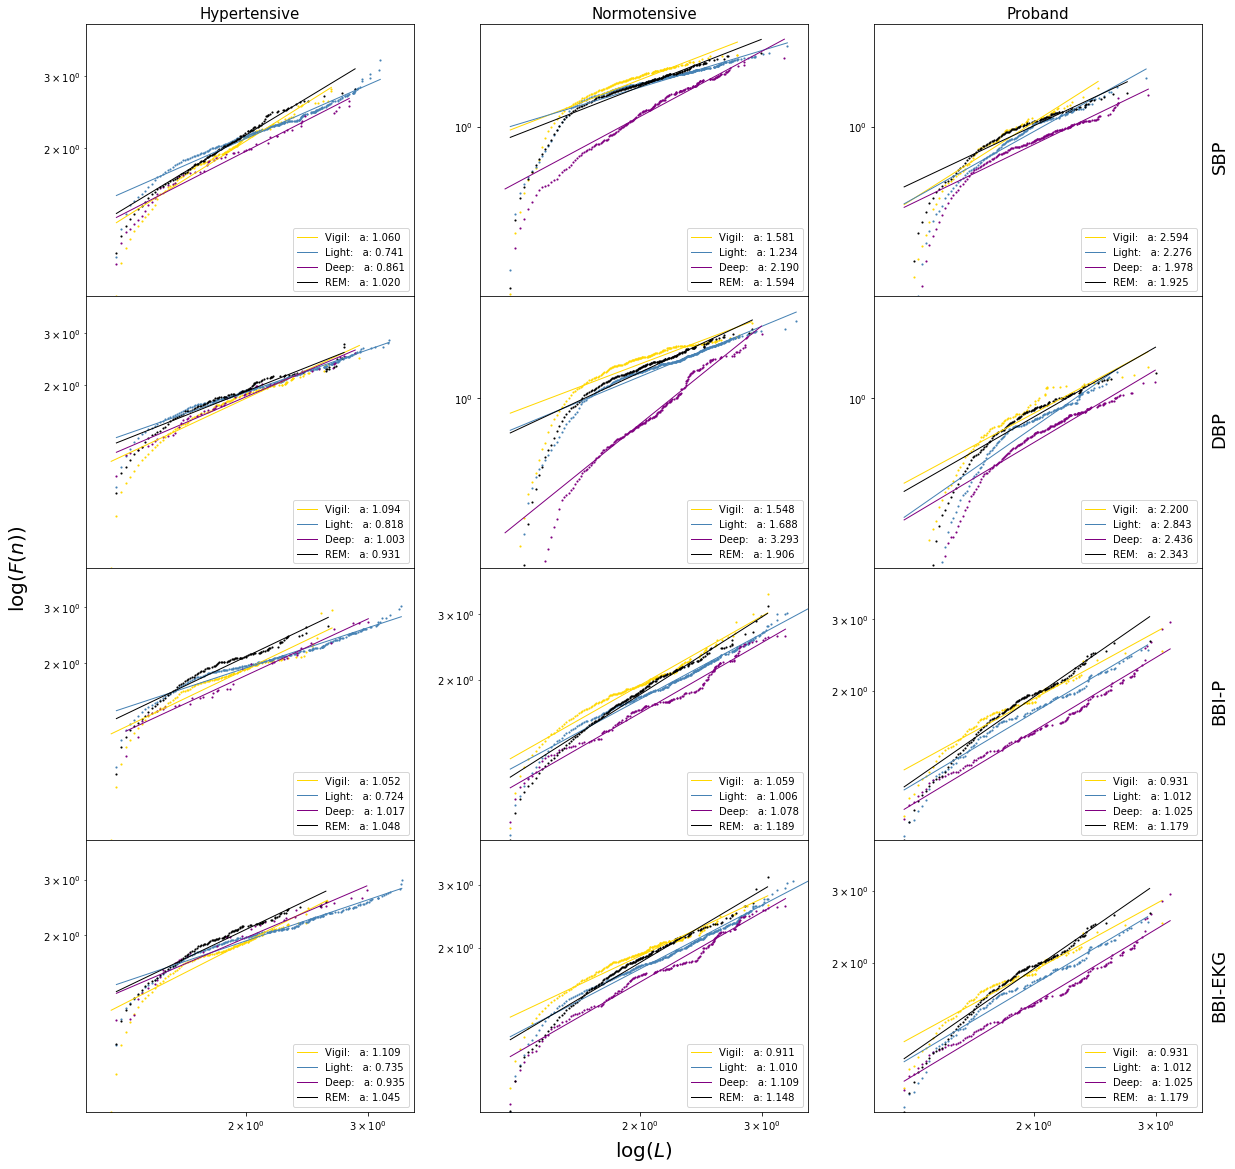

In [9]:
from scipy.optimize import curve_fit
def line(x, a, b):
    return np.power(10, a*np.log10(x) + b)

colors    = ["gold", "steelblue", "purple", "black"]
labels = ["Vigil", "Light", "Deep", "REM"]
groups = ["Hypertensive", "Normotensive", "Proband"]
series = ["SBP", "DBP", "BBI-P", "BBI-EKG"]

fig, axs = plt.subplots(nrows = 4, ncols = 3)
# Configure figure sizes and distance between axis
for item in [fig]:
    item.set_size_inches(20, 20)
    item.subplots_adjust(hspace = 0, wspace = 0.2)
        
coef_df = [pd.DataFrame(columns = ["SBP", "DBP", "BBI-P", "BBI-EKG"], index = np.arange(8)),
           pd.DataFrame(columns = ["SBP", "DBP", "BBI-P", "BBI-EKG"], index = np.arange(8)),
           pd.DataFrame(columns = ["SBP", "DBP", "BBI-P", "BBI-EKG"], index = np.arange(8))]
        
for g in range(3):
    for s in range(4):
        ax = axs[s][g]
        for p in range(4):
            stc = f_l[g][s]
            ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xlim(np.log10(15), 3.5)
            a = np.log10(min([stc[0]["coef"][0], stc[1]["coef"][0], stc[2]["coef"][0], stc[3]["coef"][0]]))
            if a < 0:
                ax.set_ylim(0.1, 4)
            else:
                ax.set_ylim(a, 4)
            
            if (len(stc) != 1):
                ax.scatter(np.log10(stc[p]["L"].values), np.log10(stc[p]["coef"].values), color = colors[p], s = 5, marker = ".", label = None)
                popt, pcov = curve_fit(line,np.log10(stc[p]["L"].values), np.log10(stc[p]["coef"].values))
                coef_df[g].loc[2*p, series[s]] = popt[0]
                coef_df[g].loc[2*p + 1, series[s]]  = np.sqrt(np.diag(pcov))[0]
                ax.plot(np.log10(stc[p]["L"].values), line(np.log10(stc[p]["L"].values), *popt), color = colors[p], linewidth = 1,
                       label = labels[p]+":   a: %5.3f" % popt[0])
                ax.legend(fontsize = 10, markerscale = 7, loc = 4)
        
        

# Configure title sizes
for i in range(4):
    for j in range(3):
        axs[i][j].xaxis.label.set_fontsize(20)
        axs[i][j].yaxis.label.set_fontsize(20)
        axs[i][j].xaxis.set_minor_locator(plt.NullLocator())
        axs[i][j].yaxis.set_minor_locator(plt.FixedLocator([2, 3]))
        axs[i][j].yaxis.set_major_locator(plt.NullLocator())
        

for i in [0, 1]:
    for j in [1, 2]:
        axs[i][j].yaxis.set_major_locator(plt.FixedLocator([1]))
        axs[i][j].yaxis.set_minor_locator(plt.NullLocator())
        
for i in [0, 1, 2]:
    axs[3][i].xaxis.set_major_locator(plt.FixedLocator([0, 1, 2, 3]))

axs[1][0].set_ylabel(r'$\log(F(n))$')
axs[1][0].yaxis.set_label_coords(-0.17,0)
axs[3][1].set_xlabel(r'$\log(L)$')
axs[3][1].xaxis.set_label_coords(0.5, -0.1)

axs[0][0].set_title("Hypertensive", size = 15)
axs[0][1].set_title("Normotensive", size = 15)
axs[0][2].set_title("Proband", size = 15)

axs[0][2].text(3.6, 0.7, "SBP", fontsize = 18, rotation = "vertical")
axs[1][2].text(3.6, 0.7, "DBP", fontsize = 18, rotation = "vertical")
axs[2][2].text(3.6, 2.0, "BBI-P", fontsize = 18, rotation = "vertical")
axs[3][2].text(3.6, 2.0, "BBI-EKG", fontsize = 18, rotation = "vertical")
        
fig.savefig("Plots/Measures/4 Groups/DFA_L/DFA_L_jumps_wline.png")
#plt.close(fig)

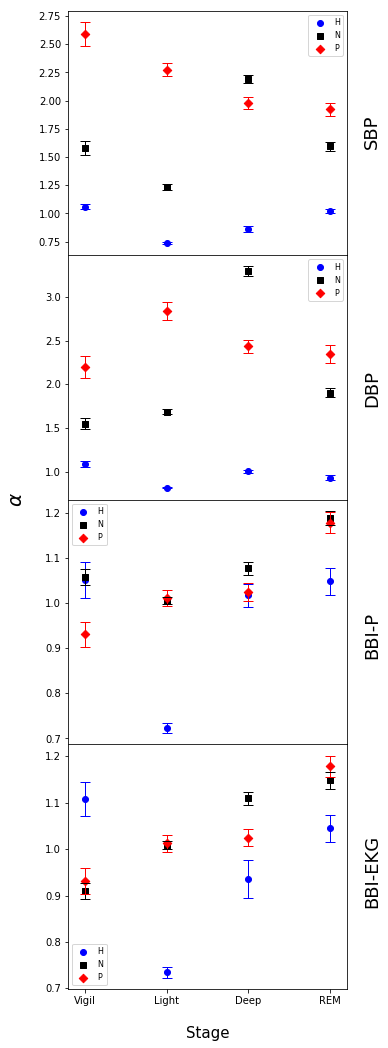

In [10]:
fig, axs = plt.subplots(nrows = 4)
# Configure fig sizes and distances between axis
for item in [fig]:
    item.set_size_inches(5, 18)
    item.subplots_adjust(hspace = 0)

# Configure title sizes
for i in range(4):
    axs[i].title.set_fontsize(14)
    axs[i].xaxis.label.set_fontsize(12)
    axs[i].yaxis.label.set_fontsize(15)
        
series = ["SBP", "DBP", "BBI-P", "BBI-EKG"]
group  = ["H", "N", "P"]
mkr = ['o', 's', 'D']
col = ["b", "k", "r"]

for s in range(4):
    ax = axs[s]
    for g in range(3):
        y = coef_df[g][series[s]][[0, 2, 4, 6]]
        y_err = coef_df[g][series[s]][[1, 3, 5, 7]]
        x = [0, 1, 2, 3]
        ax.scatter(x, y, color = col[g], marker = mkr[g], label = group[g])
        ax.errorbar(x, y, yerr = y_err, linestyle = "None", color = col[g], elinewidth = 1, capsize = 5, label = None)
        
    ax.legend(fontsize = 8, markerscale = 1)
    

for i in range(3):
    axs[i].set_xticks([])

axs[3].set_xticks([0, 1, 2, 3])
axs[3].set_xticklabels(["Vigil", "Light", "Deep", "REM"])
axs[3].set_xlabel("Stage", size = 15)
axs[1].set_ylabel(r'$\alpha$', size = 20)

axs[1].yaxis.set_label_coords(-0.15,0)
axs[3].xaxis.set_label_coords(0.5, -0.15)

#axs[0].set_yticks([0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
#axs[1].set_yticks([1, 1.25, 1.5, 1.75, 2, 2.25])
#axs[2].set_yticks([0.7, 0.8, 0.9, 1])
#axs[3].set_yticks([0.7, 0.8, 0.9, 1])

axs[0].text(3.4, 1.75, "SBP", fontsize = 18, rotation = "vertical")
axs[1].text(3.4, 2.0, "DBP", fontsize = 18, rotation = "vertical")
axs[2].text(3.4, 0.95, "BBI-P", fontsize = 18, rotation = "vertical")
axs[3].text(3.4, 1, "BBI-EKG", fontsize = 18, rotation = "vertical")
    
fig.savefig("Plots/Measures/4 Groups/DFA_L/DFA_L_jumps_meancoef.png")
#plt.close(fig)

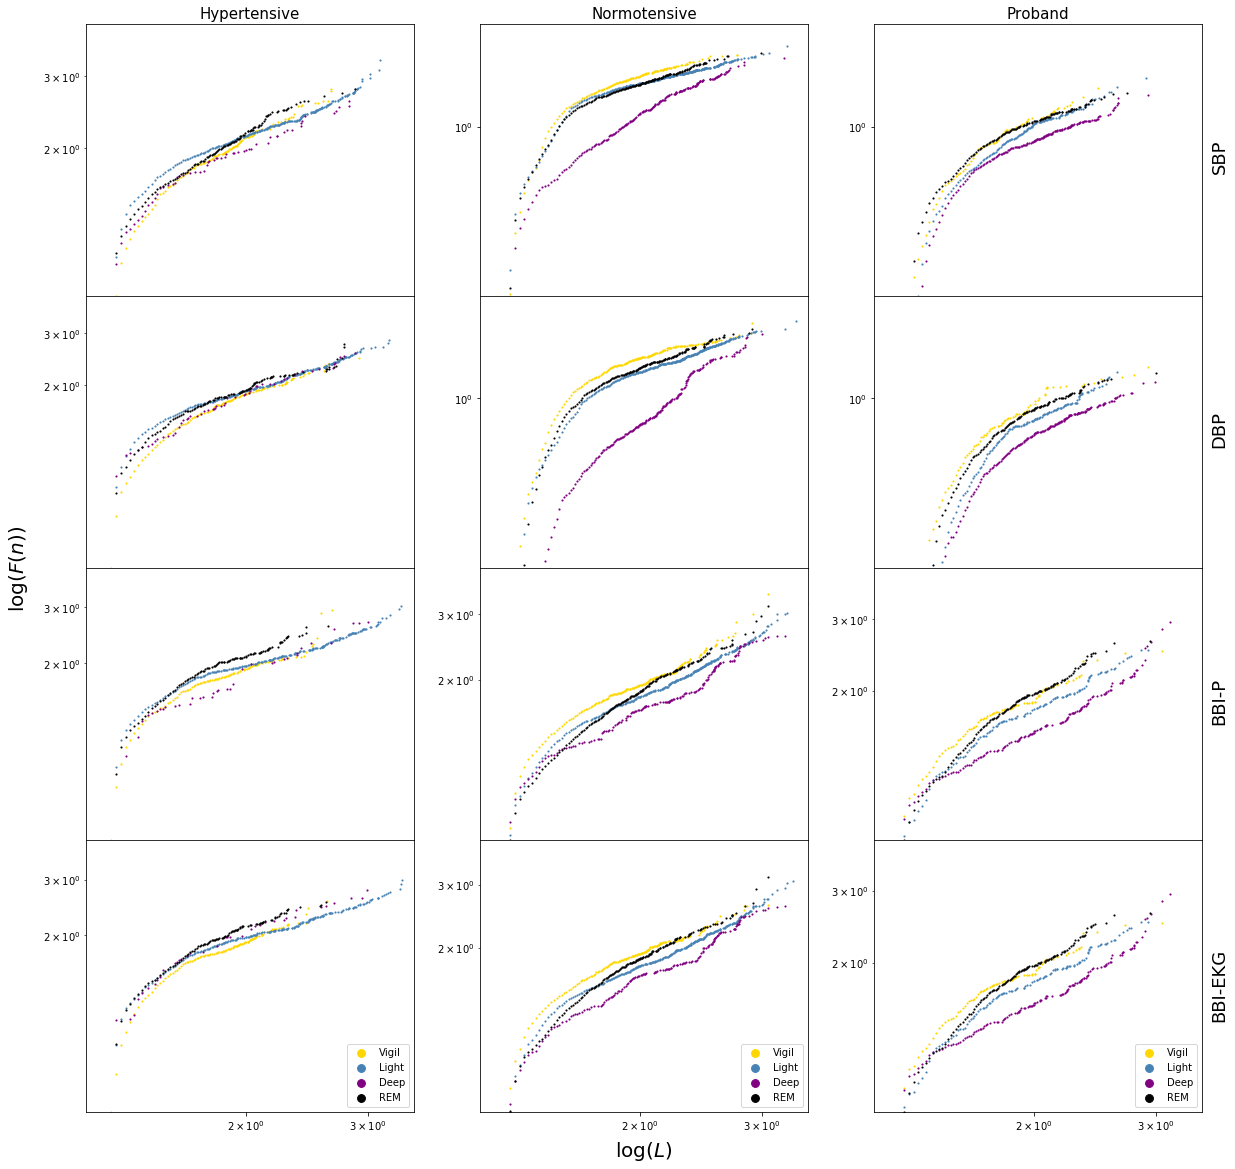

In [11]:
colors    = ["gold", "steelblue", "purple", "black"]
labels = ["Vigil", "Light", "Deep", "REM"]
groups = ["Hypertensive", "Normotensive", "Proband"]
series = ["SBP", "DBP", "BBI-P", "BBI-EKG"]

fig, axs = plt.subplots(nrows = 4, ncols = 3)
# Configure fig sizes and distance between axis
for item in [fig]:
    item.set_size_inches(20, 20)
    item.subplots_adjust(hspace = 0, wspace = 0.2)
        
for g in range(3):
    for s in range(4):
        ax = axs[s][g]
        for p in range(4):
            stc = f_l[g][s]
            ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xlim(np.log10(15), 3.5)
            a = np.log10(min([stc[0]["coef"][0], stc[1]["coef"][0], stc[2]["coef"][0], stc[3]["coef"][0]]))
            if a < 0:
                ax.set_ylim(0.1, 4)
            else:
                ax.set_ylim(a, 4)
            
            if (len(stc) != 1):
                ax.scatter(np.log10(stc[p]["L"].values), np.log10(stc[p]["coef"].values), color = colors[p], s = 5, marker = ".", label = labels[p])

for i in range(3):
    axs[3][i].legend(fontsize = 10, markerscale = 7, loc = 4)
        
        

# Config fig sizes
for i in range(4):
    for j in range(3):
        axs[i][j].xaxis.label.set_fontsize(20)
        axs[i][j].yaxis.label.set_fontsize(20)
        axs[i][j].xaxis.set_minor_locator(plt.NullLocator())
        axs[i][j].yaxis.set_minor_locator(plt.FixedLocator([2, 3]))
        axs[i][j].yaxis.set_major_locator(plt.NullLocator())
        

for i in [0, 1]:
    for j in [1, 2]:
        axs[i][j].yaxis.set_major_locator(plt.FixedLocator([1]))
        axs[i][j].yaxis.set_minor_locator(plt.NullLocator())
        
for i in [0, 1, 2]:
    axs[3][i].xaxis.set_major_locator(plt.FixedLocator([0, 1, 2, 3]))

axs[1][0].set_ylabel(r'$\log(F(n))$')
axs[1][0].yaxis.set_label_coords(-0.17,0)
axs[3][1].set_xlabel(r'$\log(L)$')
axs[3][1].xaxis.set_label_coords(0.5, -0.1)

axs[0][0].set_title("Hypertensive", size = 15)
axs[0][1].set_title("Normotensive", size = 15)
axs[0][2].set_title("Proband", size = 15)

axs[0][2].text(3.6, 0.7, "SBP", fontsize = 18, rotation = "vertical")
axs[1][2].text(3.6, 0.7, "DBP", fontsize = 18, rotation = "vertical")
axs[2][2].text(3.6, 2.0, "BBI-P", fontsize = 18, rotation = "vertical")
axs[3][2].text(3.6, 2.0, "BBI-EKG", fontsize = 18, rotation = "vertical")
        
fig.savefig("Plots/Measures/4 Groups/DFA_L/DFA_L_jumps_woline.png")
#plt.close(fig)